# 3. Classification

---

### Setup

In [1]:
import sys
sys.path.insert(1, '../../utils')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ds_functions as ds
from sklearn.model_selection import StratifiedKFold

data: pd.DataFrame = pd.read_csv('original.csv', sep=';')
data

age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0    75.0    False                       582     False                 20   
1    55.0    False                      7861     False                 38   
2    65.0    False                       146     False                 20   
3    50.0     True                       111     False                 20   
4    65.0     True                       160      True                 20   
..    ...      ...                       ...       ...                ...   
294  62.0    False                        61      True                 38   
295  55.0    False                      1820     False                 38   
296  45.0    False                      2060      True                 60   
297  45.0    False                      2413     False                 38   
298  50.0    False                       196     False                 45   

     high_blood_pressure  platelets  serum_creatinine  serum_sodium    sex  \
0                   True  265000.00               1.9           130   True   
1                  False  263358.03               1.1           136   True   
2                  False  162000.00               1.3           129   True   
3                  False  210000.00               1.9           137   True   
4                  False  327000.00               2.7           116  False   
..                   ...        ...               ...           ...    ...   
294                 True  155000.00               1.1           143   True   
295                False  270000.00               1.2           139  False   
296                False  742000.00               0.8           138  False   
297                False  140000.00               1.4           140   True   
298                False  395000.00               1.6           136   True   

     smoking  time  DEATH_EVENT  
0      False     4         True  
1      False     6         True  
2       True     7         True  
3      False     7         True  
4      False     8         True  
..       ...   ...          ...  
294     True   270        False  
295    False   271        False  
296    False   278        False  
297     True   280        False  
298     True   285        False  

[299 rows x 13 columns]

## 3.0. Training Models

---

### Training Models

---

#### StratifiedKFold function
After loading the data, in data dataframe, we need to separate the target variable which is the DEATH_EVENT from the rest of the data, since it plays a different role in the training procedure. Through the application of the pop method, we get the class variable, and simultaneously removing it from the dataframe. So, y will keep the ndarray with the target variable for each record and X the ndarray containing the records themselves

In [2]:
target = 'DEATH_EVENT'
positive = True
negative = False
values = {'Original': [len(data[data[target] == positive]), len(data[data[target] == negative])]}

y: np.ndarray = data.pop(target).values
X: np.ndarray = data.values
labels: np.ndarray = pd.unique(y)

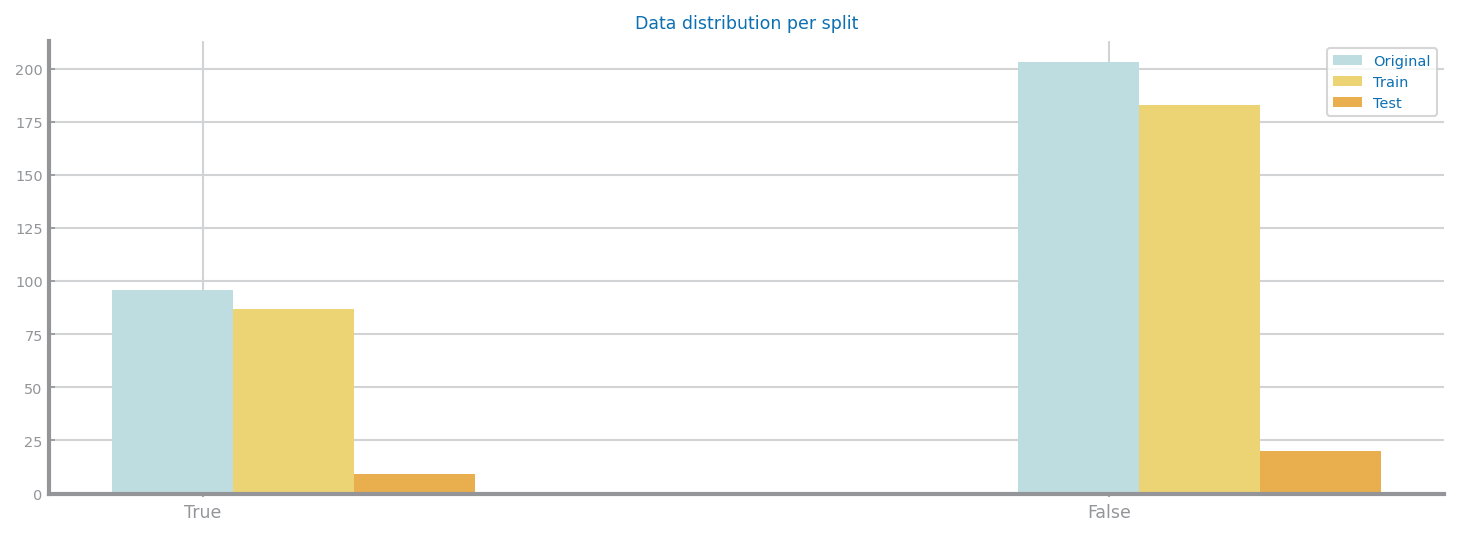

In [3]:
np.random.seed(1)
skf = StratifiedKFold(n_splits=10, shuffle=True)
skf.get_n_splits(X, y)

splits=[]

for train_index, test_index in skf.split(X, y):
    splits.append({'X_train': X[train_index], 'X_test': X[test_index],
                  'y_train': y[train_index], 'y_test': y[test_index]})

values['Train'] = [len(np.delete(y[train_index], np.argwhere(y[train_index]==negative))), len(np.delete(y[train_index], np.argwhere(y[train_index]==positive)))]
values['Test'] = [len(np.delete(y[test_index], np.argwhere(y[test_index]==negative))), len(np.delete(y[test_index], np.argwhere(y[test_index]==positive)))]

plt.figure(figsize=(12,4))
ds.multiple_bar_chart([positive, negative], values, title='Data distribution per split', showXTickLabels=True)
plt.show()

We have just plotted the chart of one split because the splits have identical distribution which will make the bar charts equal.

## 3.1. Naive Bayes

---

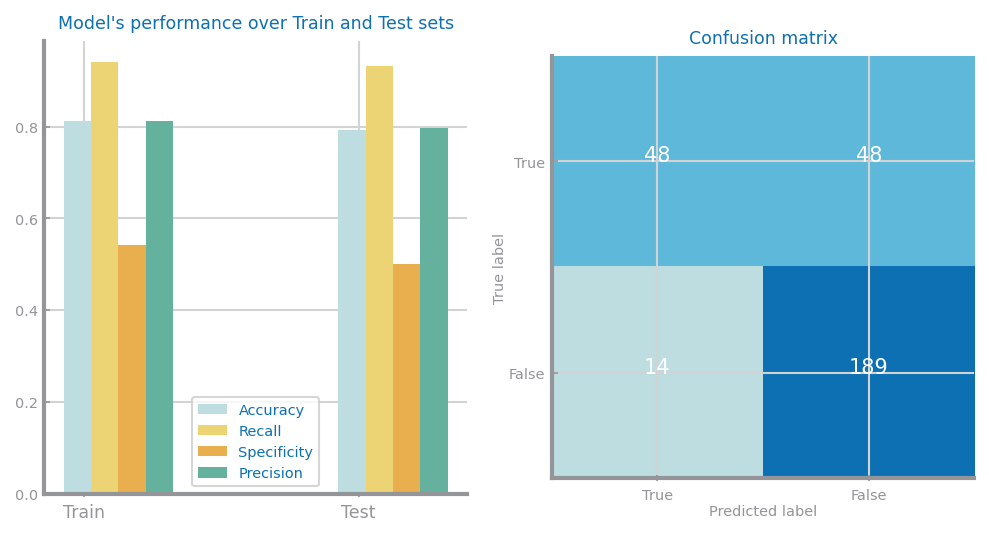

In [4]:
import sklearn.metrics as metrics
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

totalYTrn = np.array(())
totalPrd_trn = np.array(())
totalYTst = np.array(())
totalPrd_tst = np.array(())

clf = GaussianNB()
for split in splits:
    clf.fit(split['X_train'], split['y_train'])
    
    prd_trn = clf.predict(split['X_train'])
    totalYTrn = np.concatenate((totalYTrn, split['y_train']))
    totalPrd_trn = np.concatenate((totalPrd_trn, prd_trn))
    
    prd_tst = clf.predict(split['X_test'])
    totalYTst = np.concatenate((totalYTst, split['y_test']))
    totalPrd_tst = np.concatenate((totalPrd_tst, prd_tst))
    
ds.plot_evaluation_results(labels, totalYTrn, totalPrd_trn, totalYTst, totalPrd_tst, showXTickLabels=True)

Mean values:
GaussianNB: 0.793
MultinomialNB: 0.642
BernoulliNB: 0.679
95% cofidence interval for accuracy:
GaussianNB: [0.743,0.843]
MultinomialNB: [0.605,0.68]
BernoulliNB: [0.67,0.688]
99% cofidence interval for accuracy:
GaussianNB: [0.717,0.87]
MultinomialNB: [0.585,0.7]
BernoulliNB: [0.666,0.692]


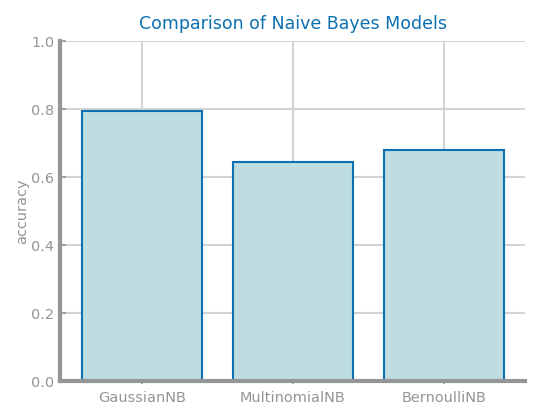

In [9]:
estimators = {'GaussianNB': GaussianNB(),
              'MultinomialNB': MultinomialNB(),
              'BernoulliNB': BernoulliNB()}

xvalues = [est for est in estimators]
yvalues = [np.zeros(10) for _ in estimators]

for spli in range(len(splits)):
    split = splits[spli]
    for i in range(len(xvalues)):
        clf = xvalues[i]
        estimators[clf].fit(split['X_train'], split['y_train'])
        prdY = estimators[clf].predict(split['X_test'])
        yvalues[i][spli] = metrics.accuracy_score(split['y_test'], prdY)

estimator_names = ('GaussianNB', 'MultinomialNB', 'BernoulliNB')
means = [np.mean(accs) for accs in yvalues]
stds = [np.std(accs) for accs in yvalues]
confidences = (0.95, 0.99)
t_st = (1.812, 2.764)

print("Mean values:")
for est in range(len(estimators)):
    print(f'{estimator_names[est]}: {round(means[est], 3)}')

for c in range(len(confidences)):
    conf = confidences[c]
    print(f'{int(conf*100)}% cofidence interval for accuracy:')
    for est in range(len(estimators)):
        minAcc = means[est] - t_st[c] * stds[est] / (10**0.5)
        maxAcc = means[est] + t_st[c] * stds[est] / (10**0.5)
        print(f'{estimator_names[est]}: [{round(minAcc, 3)},{round(maxAcc, 3)}]')

plt.figure()
ds.bar_chart(xvalues, means, title='Comparison of Naive Bayes Models', ylabel='accuracy', percentage=True)
plt.show()

### Summary

---

***Which distribution is more adequate to model our data?***

For most of the splits, the Gaussian distribution models better our data.

***Is the accuracy achieved good enough?***

The accuracy is better than the one of the classifier that considers every record is negative. However, this doesn't mean the classifier is good enough. We still consider it is not very good.

***What is the largest kind of errors?***

False negatives.